In [1]:
%matplotlib inline
import torch
import torchaudio
import numpy as np
import librosa
import matplotlib.pyplot as plt
import torch_dct
import IPython.display as ipd

In [2]:
def play_audio(audio, sr=16000):
    audio = audio.numpy().astype(np.float32)
    ipd.display(ipd.Audio(audio, rate=sr))

In [3]:
CLEAN_FILE = "clean.wav"
NOISE_FILE = "noise.wav"
RIR_FILE = "rir.wav"

In [4]:
clean, sr = torchaudio.load(CLEAN_FILE)
if sr != 16000:
    clean = torchaudio.functional.resample(clean, sr, 16000)
noise, sr = torchaudio.load(NOISE_FILE)
if sr != 16000:
    noise = torchaudio.functional.resample(noise, sr, 16000)
rir, sr = torchaudio.load(RIR_FILE)
if sr != 16000:
    rir = torchaudio.functional.resample(rir, sr, 16000)
sr = 16000
play_audio(clean)
play_audio(noise)
play_audio(rir)

In [5]:
def add_reverb(clean, rir):
    if rir.shape[0] > 1:
        rir = rir.mean(0, keepdim=True)
    clean = clean.squeeze()
    rir = rir.squeeze()
    reverb = torchaudio.functional.fftconvolve(clean, rir)
    return reverb[:clean.shape[0]]

reverb = add_reverb(clean, rir)
play_audio(reverb)

In [6]:
def add_noise(clean, noise, target_snr):
    clean = clean.squeeze()
    noise = noise.squeeze()
    if noise.shape[0] < clean.shape[0]:
        torch.nn.functional.pad(noise, (0, clean.shape[0] - noise.shape[0]))
    else:
        noise = noise[:clean.shape[0]]
    noisy = torchaudio.functional.add_noise(clean.unsqueeze(0), noise.unsqueeze(0), torch.IntTensor([target_snr]))
    return noisy

snr = -15
noisy = add_noise(clean, noise, snr)
play_audio(noisy)
reverb_noisy = add_noise(reverb, noise, snr)
play_audio(reverb_noisy)

In [7]:
def torch_frame(audio, frame_length, hop_length, window=None):
    frames = audio.unfold(-1, frame_length, hop_length)
    if window is not None:
        frames = frames * window
    return frames

frame_length = 512
hop_length = 128
num_frame = int((clean.shape[-1] - frame_length) // hop_length)+1
print(num_frame)
print(clean.shape)
print(torch_frame(clean, frame_length=frame_length, hop_length=128).shape)

1007
torch.Size([1, 129280])
torch.Size([1, 1007, 512])


In [8]:
stft = librosa.stft(clean.numpy(), n_fft=frame_length, hop_length=hop_length)
print(stft.shape)

(1, 257, 1011)


In [9]:
stft_recon = librosa.istft(stft, n_fft=frame_length, hop_length=hop_length)
play_audio(torch.from_numpy(stft_recon))

Text(0.5, 1.0, 'DCT Spectrogram (dB)')

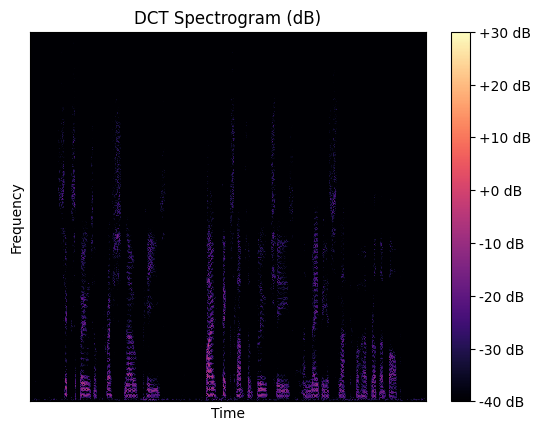

In [8]:
def stdct(audio, frame_length, hop_length, window=None):
    frames = torch_frame(audio, frame_length, hop_length, window)
    return torch_dct.dct(frames, norm='ortho')

window = torch.hann_window(frame_length)
# window = None

dct = stdct(clean.unsqueeze(0), frame_length=frame_length, hop_length=hop_length, window=window)
magnitude = dct.permute(0, 1, 3, 2).abs().numpy()
log_spectrogram = librosa.amplitude_to_db(magnitude)
plt.figure()
librosa.display.specshow(log_spectrogram.squeeze(), sr=sr, vmin=-40, vmax=30, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("DCT Spectrogram (dB)")


torch.Size([1, 1007, 512])
torch.Size([1, 1007, 512])
torch.Size([1, 129280])


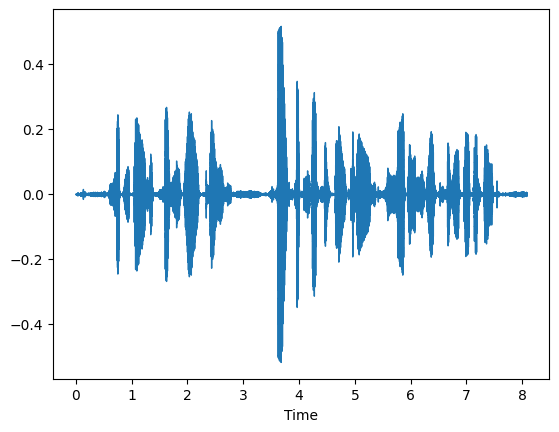

In [20]:
def istdct(dct, frame_length, hop_length, window=None):
    frames = torch_dct.idct(dct, norm='ortho').squeeze(1)
    num_frames = frames.shape[-2]
    print(frames.shape)
    audio = torch.zeros((frames.shape[0], num_frames * hop_length + frame_length - hop_length))
    overlap = torch.zeros((frames.shape[0], num_frames * hop_length + frame_length - hop_length))
    if window is None:
        window = torch.ones((frame_length))
    print(frames.shape)
    print(audio.shape)
    for i in range(num_frames):
        audio[:, i * hop_length:i * hop_length + frame_length] += frames[:, i, :]
        overlap[:, i * hop_length:i * hop_length + frame_length] += window
    overlap = overlap.clamp(min=1e-8)
    audio /= overlap
    return audio

window = torch.hann_window(frame_length)
dct_recon = istdct(dct, frame_length=frame_length, hop_length=hop_length, window=window)
play_audio(dct_recon)

# plot waveform
librosa.display.waveshow(clean.numpy(), sr=sr)

In [22]:
window = torch.hamming_window(frame_length)
batch = torch_frame(clean, frame_length=16384, hop_length=8192).permute(1, 0, 2)
print(batch.shape)
batch_stdct = stdct(batch, frame_length=frame_length, hop_length=hop_length, window=window)
print(batch_stdct.shape)
batch_recon = istdct(batch_stdct, frame_length=frame_length, hop_length=hop_length, window=window)
print(batch_recon.shape)
for i in range(batch_recon.shape[0]):
    play_audio(batch_recon[i])


torch.Size([14, 1, 16384])
torch.Size([14, 1, 125, 512])
torch.Size([14, 125, 512])
torch.Size([14, 125, 512])
torch.Size([14, 16384])
torch.Size([14, 16384])


(1, 1007, 512)


Text(0.5, 1.0, 'DCT Spectrogram (dB)')

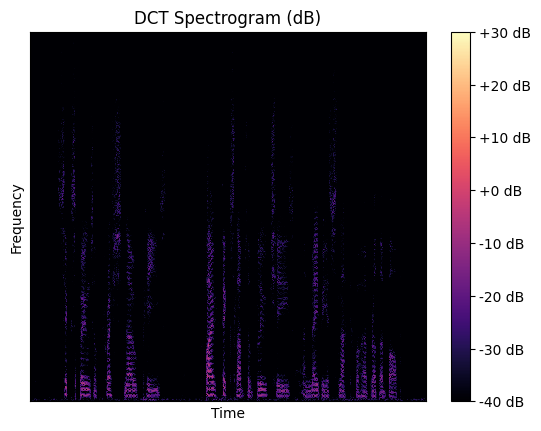

In [12]:
import tensorflow as tf
def frame(signals, frame_length, frame_step, winfunc=tf.signal.hamming_window):
  framed_signals = tf.signal.frame(signals, frame_length, frame_step, pad_end=False)
  if winfunc is not None:
    window = winfunc(frame_length, dtype=tf.float32)
    framed_signals *= window
  return framed_signals

def over_lap_and_add(framed_signals, frame_length, frame_step, winfunc=tf.signal.hamming_window):
  """overlap and add
  params：
    framed_signals: tf.float32, shape=[batch, n_frames, frame_length]
    frame_length: Window length
    frame_step: frame shift
  return：
    signals: tf.float32, shape=[batch, x_length]
  """
  shape = tf.shape(framed_signals)
  n_frames = shape[1]
  # Generate de-overlapping windows
  if winfunc is not None:
    window = winfunc(frame_length, dtype=tf.float32)
    window = tf.reshape(window, [1, frame_length])
    window = tf.tile(window, [n_frames, 1])
    window = tf.signal.overlap_and_add(window, frame_step)
  signals = tf.signal.overlap_and_add(framed_signals, frame_step)
  signals /= window
  signals = tf.cast(signals, tf.float32)
  return signals

def Analysis(signals, frame_length, frame_step):
  """
  signals: shape=[batch, height]
  return
    spec_real: tf.float32, shape=[batch, n_frames, fft_length]"""
  with tf.name_scope("Analysis"):
    # frame
    framed_signals = frame(signals, frame_length, frame_step)
    # DFT
    spec = tf.signal.dct(framed_signals, type=2, norm='ortho')

    spec_real = tf.cast(spec, tf.float32)
    spec_real = spec_real.numpy()

  return spec_real


sig = clean.numpy()
tfsignal = Analysis(sig, frame_length, hop_length)
print(tfsignal.shape)

magnitude = np.abs(tfsignal.transpose()).squeeze()

log_spectrogram = librosa.amplitude_to_db(magnitude)

plt.figure()
librosa.display.specshow(log_spectrogram, sr=sr, vmin=-40, vmax=30, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("DCT Spectrogram (dB)")


In [40]:
def Synthesis(spec, frame_length, frame_step):
  """
  spec: float32, shape=[batch, n_frames, fft_length]"""
  with tf.name_scope("Synthesis"):
    # iDFT
    signal_f = tf.signal.idct(spec, type=2, norm='ortho')
    # Recovery signal
    signals = over_lap_and_add(signal_f, frame_length, frame_step)
  return signals
recon = Synthesis(tfsignal, frame_length, hop_length)
play_audio(recon)